## Kalashnik 1994


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [101]:
PARAMS = {'save_figs':       False,
#           'data_dir':        '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
          'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
#           'ds_glob_path_Rw': '/home/arthur/data/cyclobs/SAR_compilations_in_nc/ds_glob_Rw',
#           'save_dir':        '/home/arthur/results/ck22model/ck22model_scatter/lat30_cat1_allbasins/',
          
#           'filter_data':     True, # If True, filters out storms and TC > 30°N
}

### OPEN DATA
dsg = xr.open_dataset(PARAMS['ds_glob_path'])
# ds_glob = xr.open_dataset(PARAMS['ds_glob_path_Rw'])
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 335


In [3]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def h80(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((r / rm) ** B) * np.exp(1 - (r / rm) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

3776230.4271288
2198118.4245497063
1605382.5319597875
1287872.8215070216


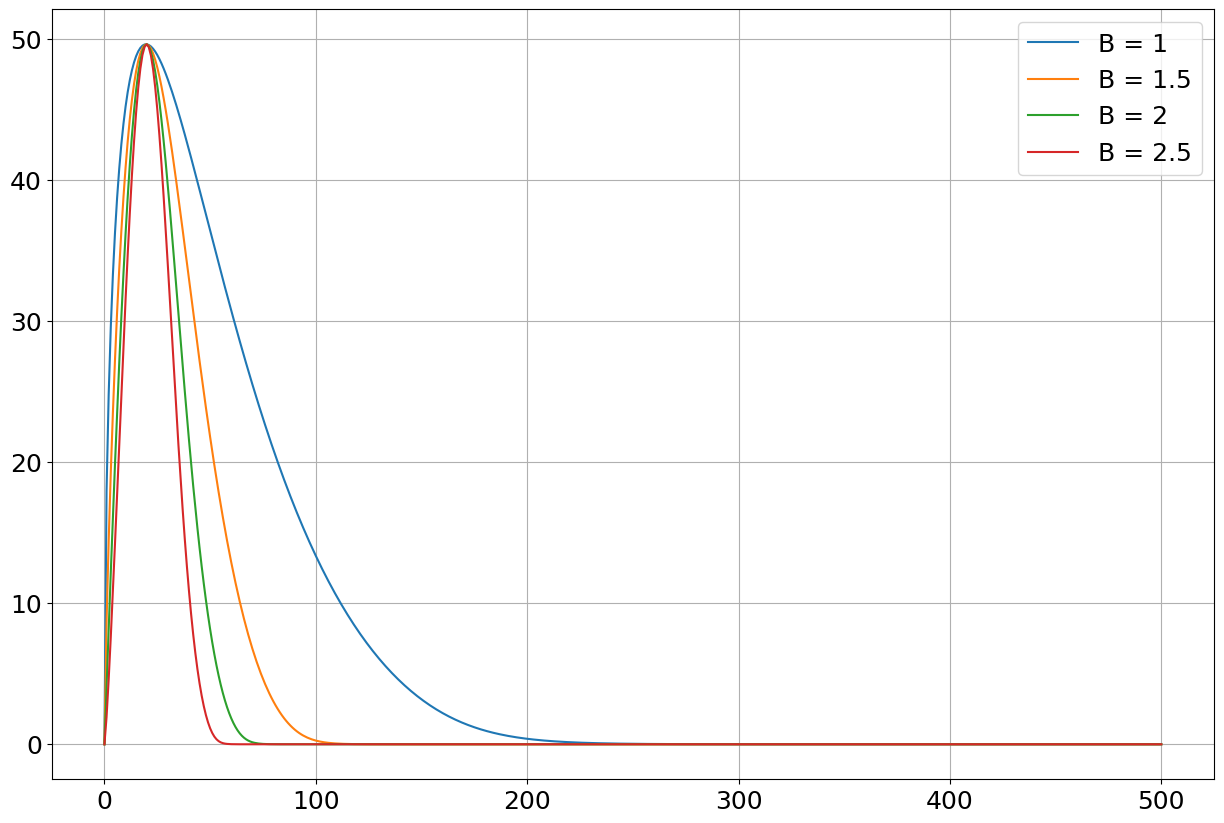

In [4]:
r   = np.linspace(0, 5e5, 50001)
B   = 1
vm  = 50
rm  = 20000
lat = 15
for B in [1, 1.5, 2, 2.5]:
    v = h80(r, vm, rm, B, lat)
    plt.plot(r / 1000, h80(r, vm, rm, B, lat), label='B = {}'.format(B))
    print(np.trapz(v, x=r))
plt.grid();plt.legend()

In [5]:
def left_term(r, v):
    '''Integral of r v ^3'''
    return np.trapz(r * v ** 3, x=r)

def right_term(r, v, lat):
    '''Right term'''
    dr   = 1000 # meters
    vort = (1 / r) * np.gradient(r * v, dr)
    q    = (r * v ** 2) / (vort + coriolis(lat))
    # idx  = np.argmax(q) # w_ekman zeroes when q reaches its maximum (because then derivative is null)
    return np.max(q)

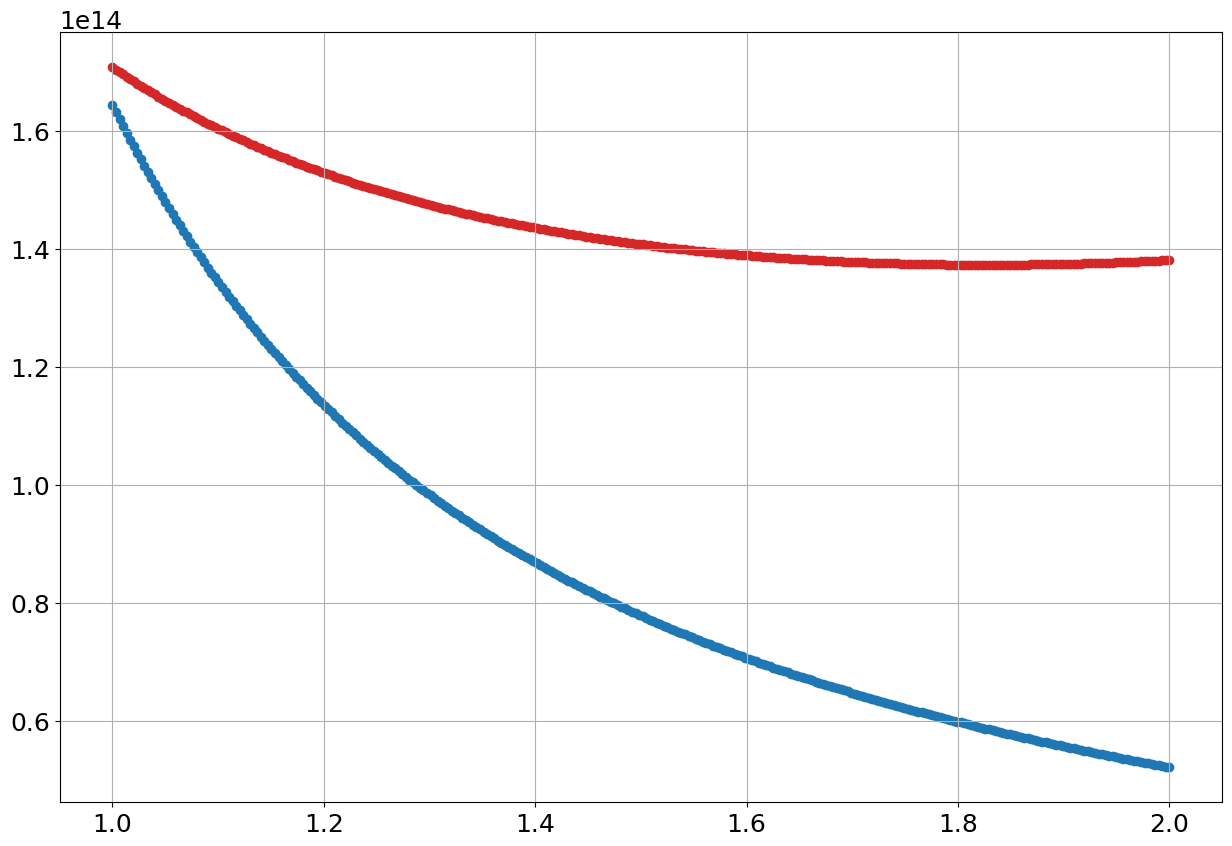

In [18]:
r   = np.linspace(0, 5e5, 50001)
vm  = 50
rm  = 20000
lat = 15
for B in np.linspace(1, 2, 300):
    v = h80(r, vm, rm, B, lat)
    plt.scatter(B, left_term(r, v), c='tab:blue')

for B in np.linspace(1, 2, 300):
    v = h80(r, vm, rm, B, lat)
    plt.scatter(B, 100 * right_term(r, v, lat), c='tab:red')
plt.grid()

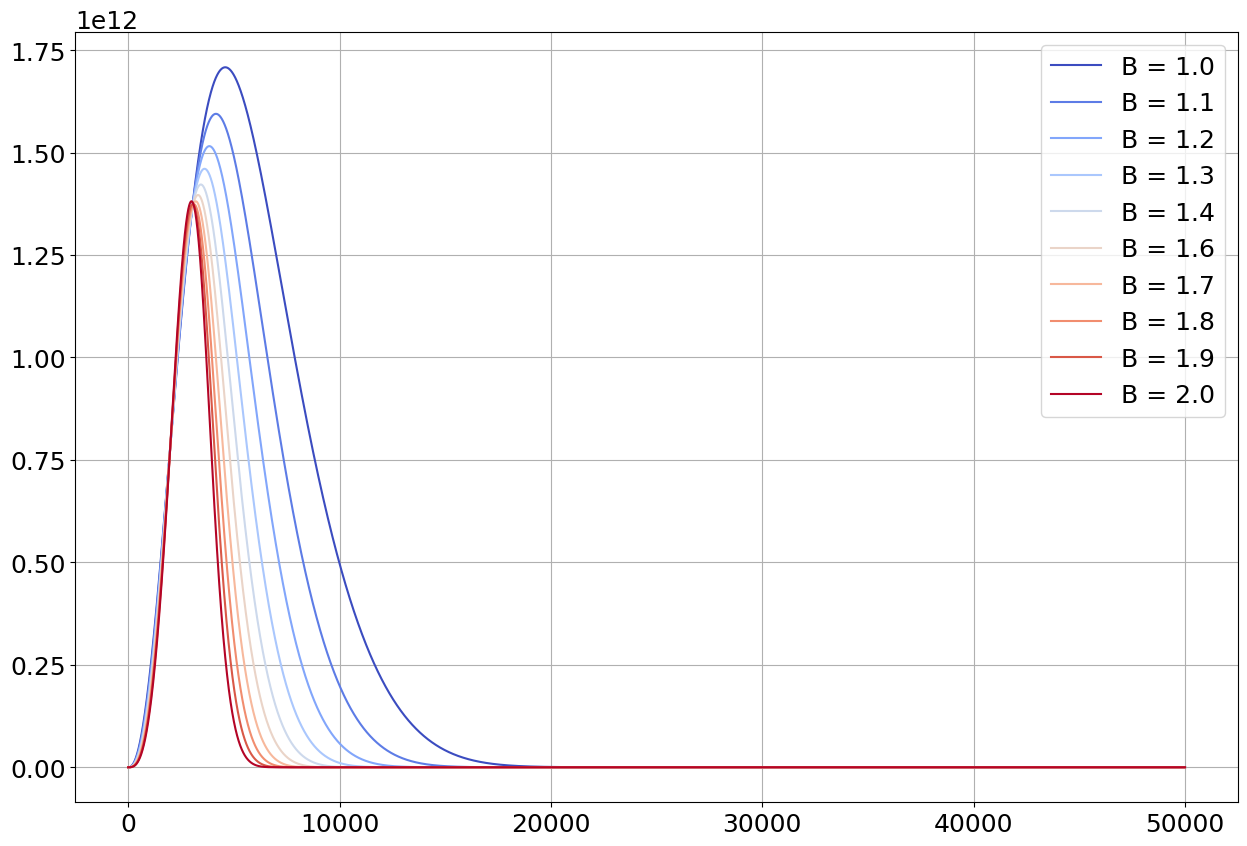

In [23]:
dr     = 1000 # meters
Bs     = np.linspace(1, 2, 10)
colors = mpl.cm.coolwarm(np.linspace(0, 1, len(Bs)))
for i, B in enumerate(Bs):
    v    = h80(r, vm, rm, B, lat)
    vort = (1 / r) * np.gradient(r * v, dr)
    # plt.plot(vort)
    # plt.plot(1 / (vort + coriolis(lat)), c=colors[i], label='B = {}'.format(B))
    q    = (r * v ** 2) / (vort + coriolis(lat))
    plt.plot(q, c=colors[i], label='B = {:.1f}'.format(B))
    # print(right_term(r, v, lat))
plt.legend()
plt.grid()

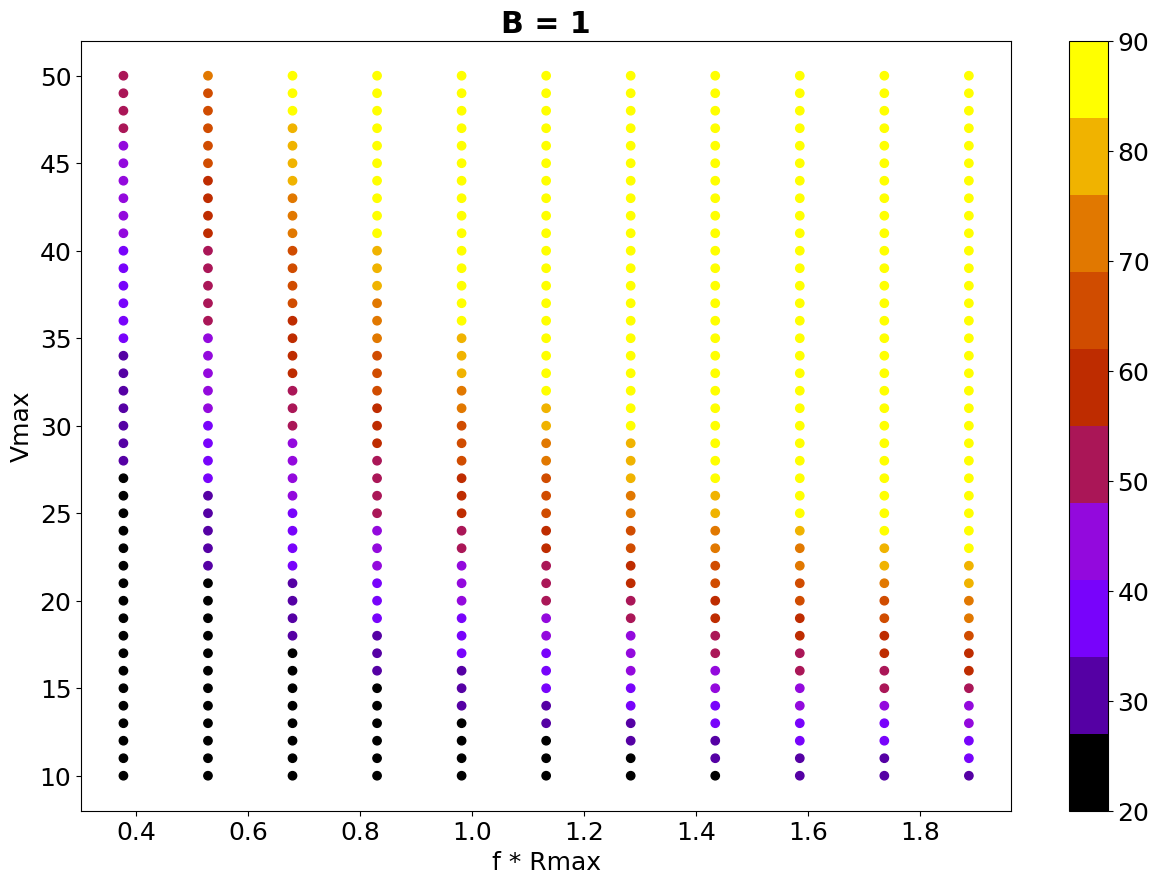

In [67]:
cmap = cm.get_cmap('gnuplot', 10)
r   = np.linspace(0, 5e5, 50001)
B   = 1
lat = 15

xs = []
ys = []
cs = []
for rm in np.linspace(10000, 50000, 11):
    for vm in np.linspace(10, 50, 41):
        v = h80(r, vm, rm, B, lat)
        xs.append(rm * coriolis(lat))
        ys.append(vm)
        cs.append(left_term(r, v) / right_term(r, v, lat))

plt.title('B = {}'.format(B), weight='bold')
plt.xlabel('f * Rmax');plt.ylabel('Vmax')
plt.scatter(xs, ys, c=cs, cmap=cmap, vmin=20, vmax=90);plt.colorbar()

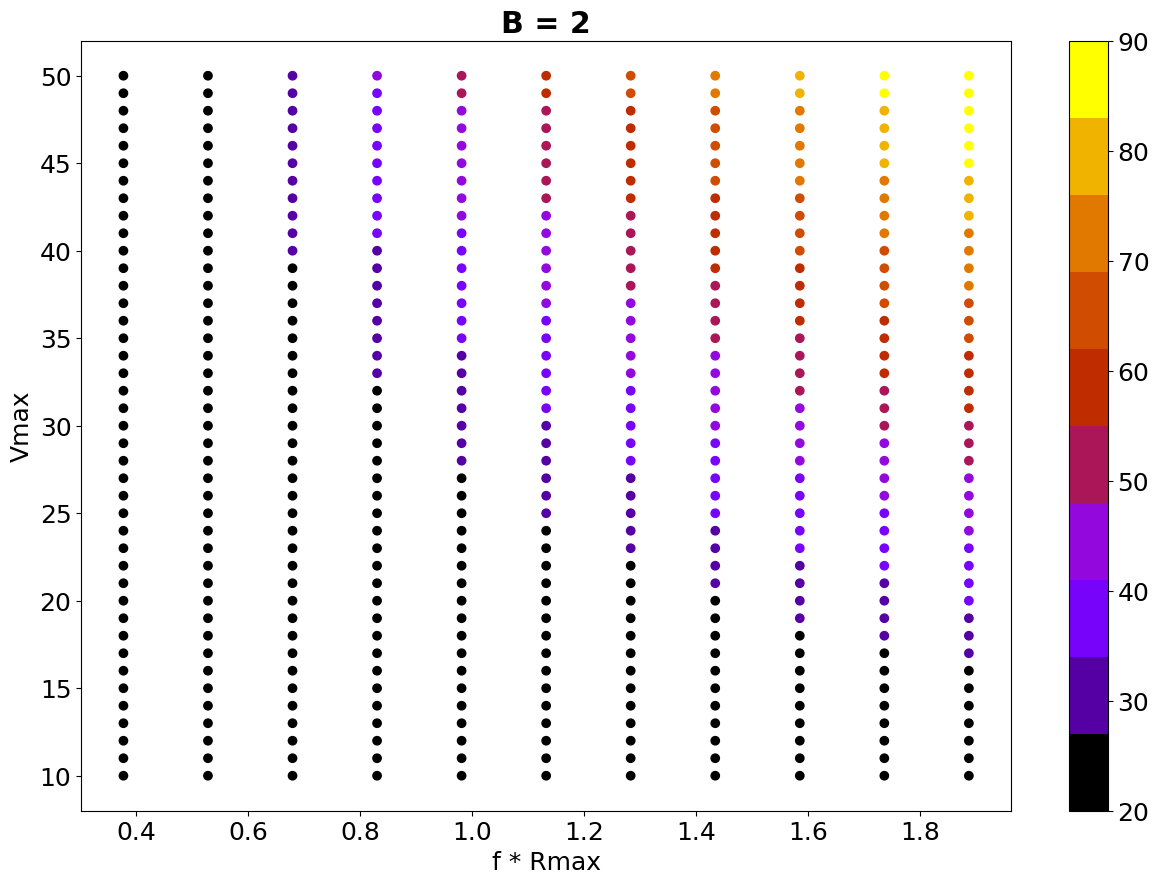

In [68]:
cmap = cm.get_cmap('gnuplot', 10)
r   = np.linspace(0, 5e5, 50001)
B   = 2
lat = 15

xs = []
ys = []
cs = []
for rm in np.linspace(10000, 50000, 11):
    for vm in np.linspace(10, 50, 41):
        v = h80(r, vm, rm, B, lat)
        xs.append(rm * coriolis(lat))
        ys.append(vm)
        cs.append(left_term(r, v) / right_term(r, v, lat))

plt.title('B = {}'.format(B), weight='bold')
plt.xlabel('f * Rmax');plt.ylabel('Vmax')
plt.scatter(xs, ys, c=cs, cmap=cmap, vmin=20, vmax=90);plt.colorbar()

In [93]:
def cost(vm, r, rm, B, lat):
    v = h80(r, vm, rm, B, lat)
    return left_term(r, v) - 10 * right_term(r, v, lat)

100%|███████████████████████████████████████████| 10/10 [00:02<00:00,  5.00it/s]


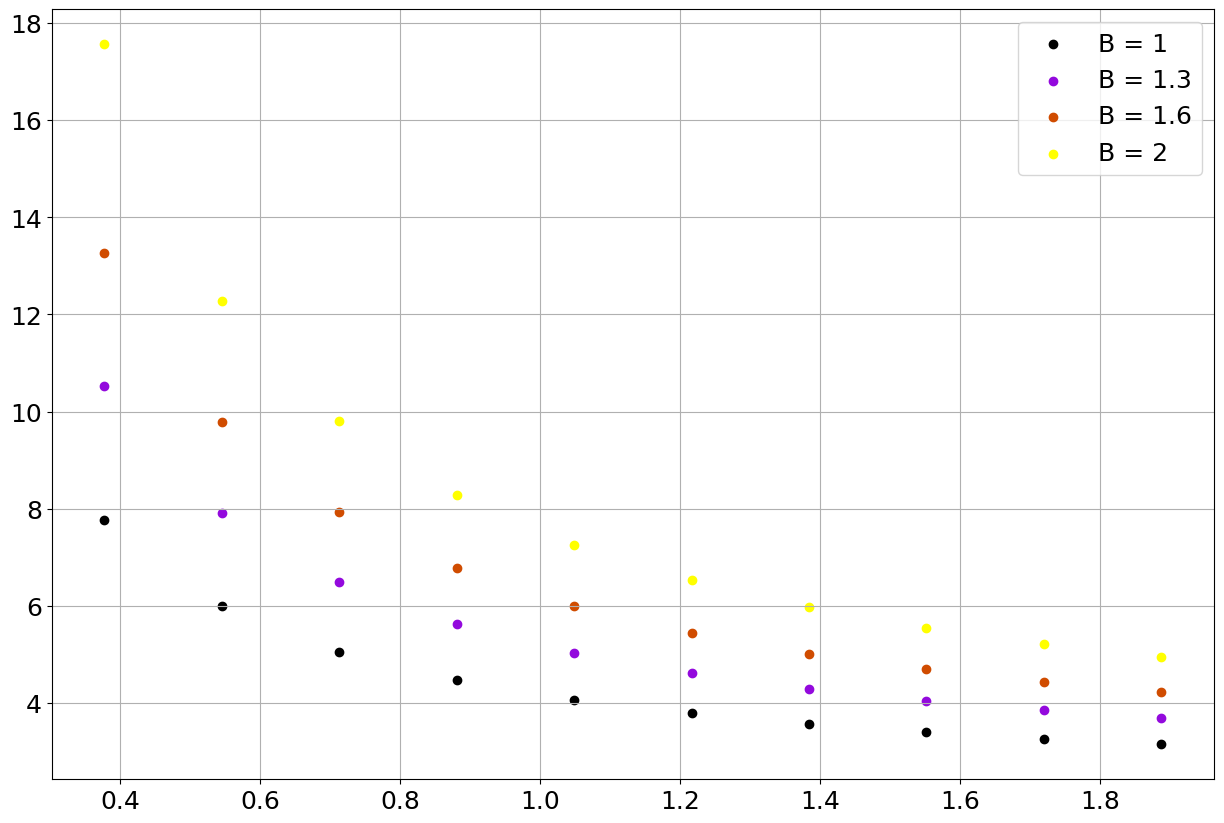

In [98]:
from scipy.optimize import minimize
Bs     = [1, 1.3, 1.6, 2]
colors = mpl.cm.gnuplot(np.linspace(0, 1, len(Bs)))
# colors = ['blue', 'red', 'green']
rm  = 20000
lat = 15

for i, B in enumerate(Bs):
    vms = []
    rms = []
    for rm in tqdm(np.linspace(10000, 50000, 10)):
        res = minimize(lambda vm: cost(vm, r, rm, B, lat), x0=1)
        vms.append(res.x)
        # print(res.success)
        rms.append(rm)
    plt.scatter(coriolis(lat) * np.array(rms), np.array(vms), color=colors[i], label='B = {}'.format(B))
plt.grid()
plt.legend()

Text(0, 0.5, 'Vmax')

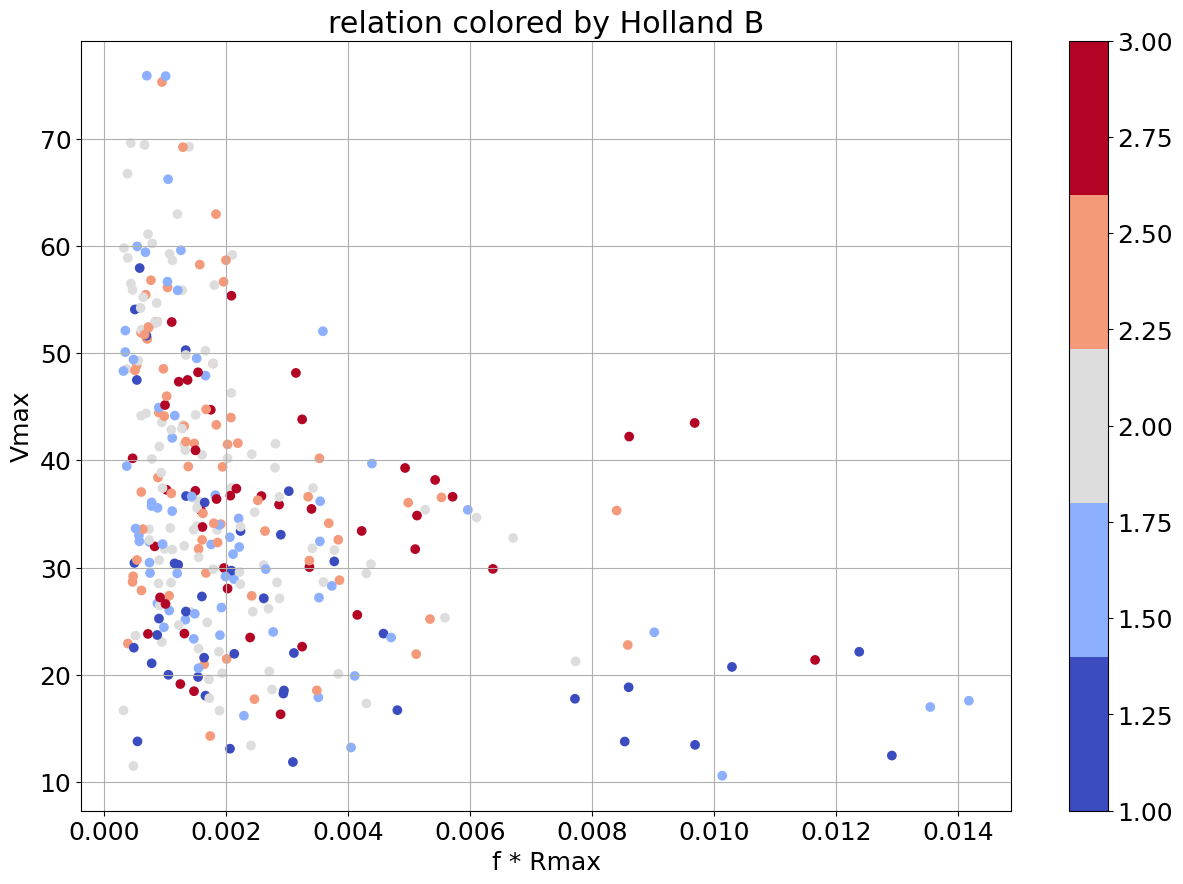

In [ ]:
dsg['fcor'] = coriolis(dsg.lat_center)
plt.title('relation colored by Holland B')
plt.scatter(dsg.Rmax_1D * abs(dsg.fcor), dsg.Vmax_1D, c=dsg.B_hol, vmin=1, vmax=3, cmap=cm.get_cmap('coolwarm', 5));plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')

(array([ 1.,  0.,  1.,  1.,  2.,  2.,  5.,  3.,  4., 11.,  7.,  5., 14.,
        13.,  5., 24., 20., 23., 26., 25., 19., 14., 22., 16., 12., 14.,
         7.,  7.,  8.,  9.,  3.,  5.,  0.,  2.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.40958268, 0.4939519 , 0.57832112, 0.66269034, 0.74705956,
        0.83142879, 0.91579801, 1.00016723, 1.08453645, 1.16890567,
        1.25327489, 1.33764411, 1.42201333, 1.50638255, 1.59075177,
        1.67512099, 1.75949021, 1.84385944, 1.92822866, 2.01259788,
        2.0969671 , 2.18133632, 2.26570554, 2.35007476, 2.43444398,
        2.5188132 , 2.60318242, 2.68755164, 2.77192086, 2.85629009,
        2.94065931, 3.02502853, 3.10939775, 3.19376697, 3.27813619,
        3.36250541, 3.44687463, 3.53124385, 3.61561307, 3.69998229,
        3.78435151, 3.86872074, 3.95308996, 4.03745918, 4.1218284 ,
        4.20619762, 4.29056684, 4.37493606, 4.45930528, 4.5436745 ,
        4.62804372]),
 <BarContainer

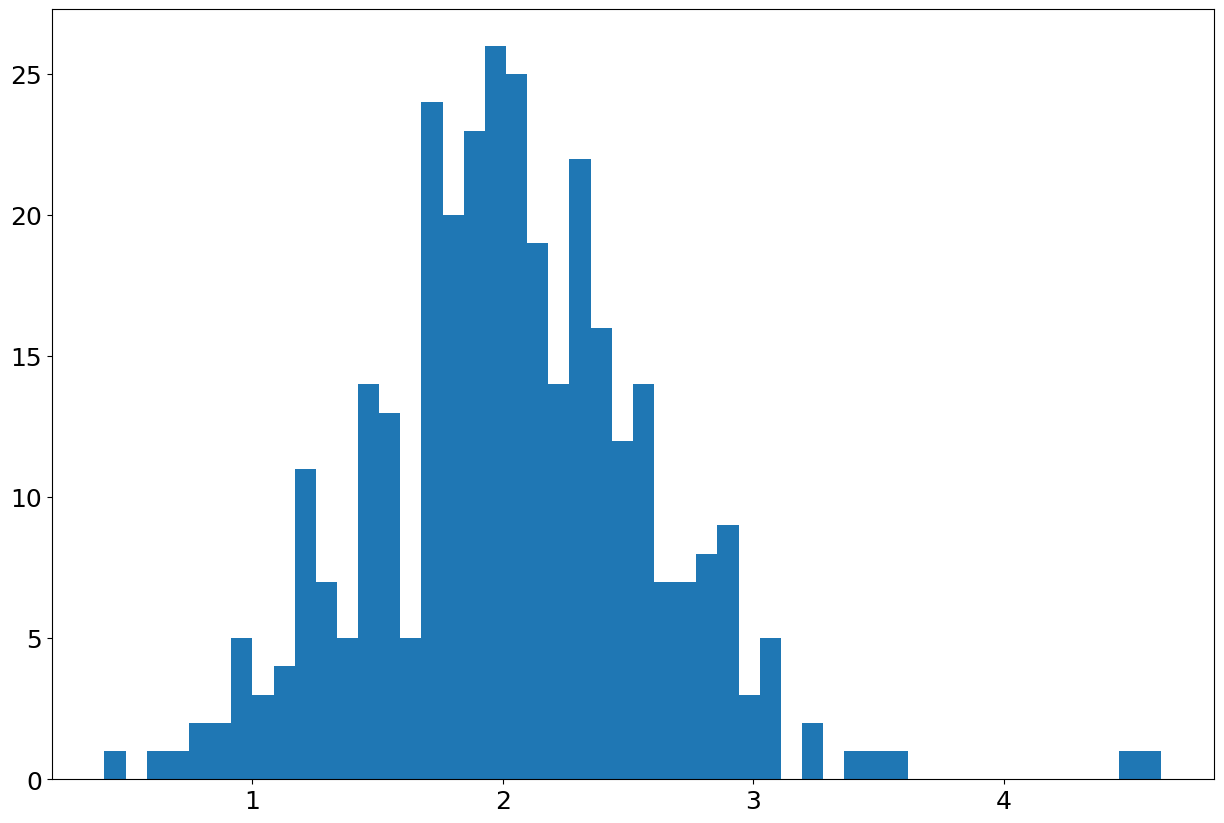

In [124]:
plt.hist(dsg.B_hol, bins=50)

Text(0, 0.5, 'Vmax')

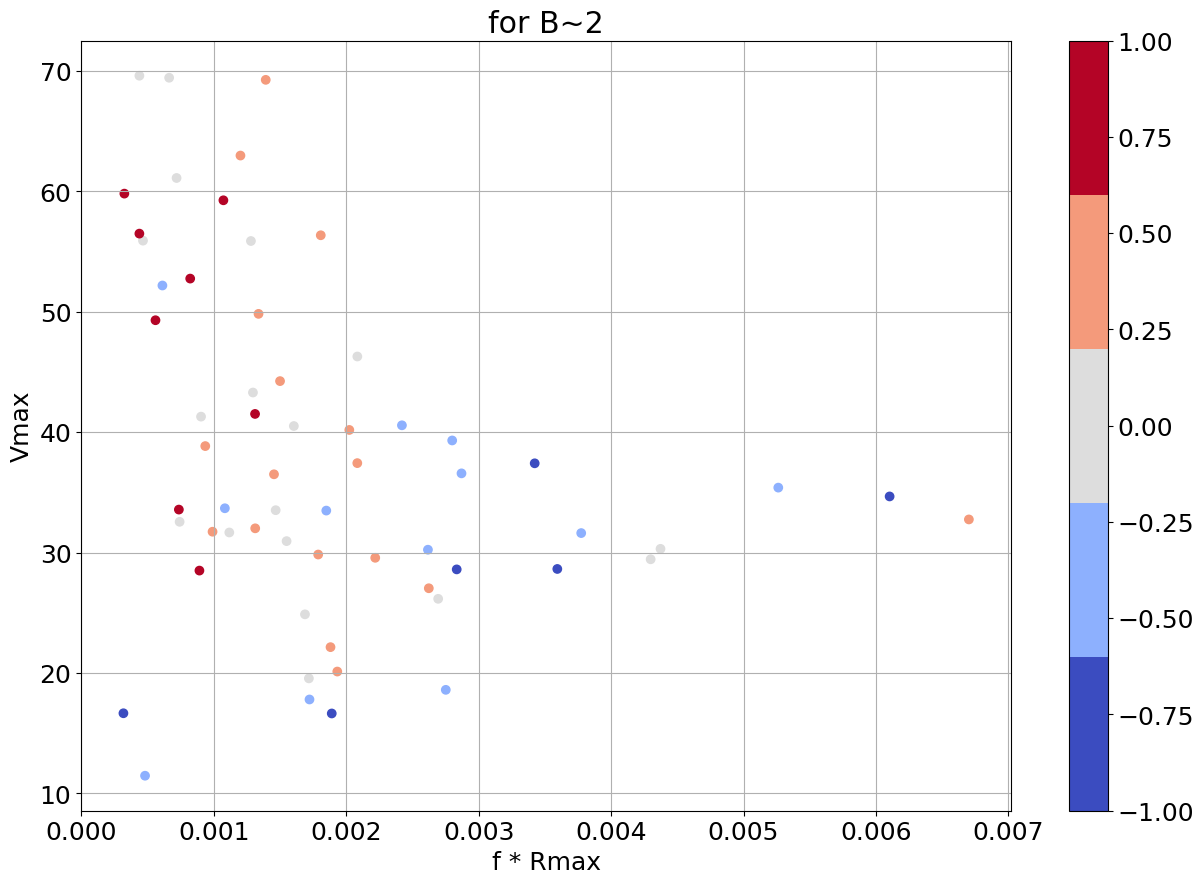

In [138]:
d = dsg.where(abs(dsg.B_hol - 2) < 0.1, drop=True)
plt.title('for B~2')
plt.scatter(d.Rmax_1D * abs(d.fcor), d.Vmax_1D, c=d.curr_inten, cmap=cm.get_cmap('coolwarm', 5), vmin=-1, vmax=1);plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')

Text(0, 0.5, 'Vmax')

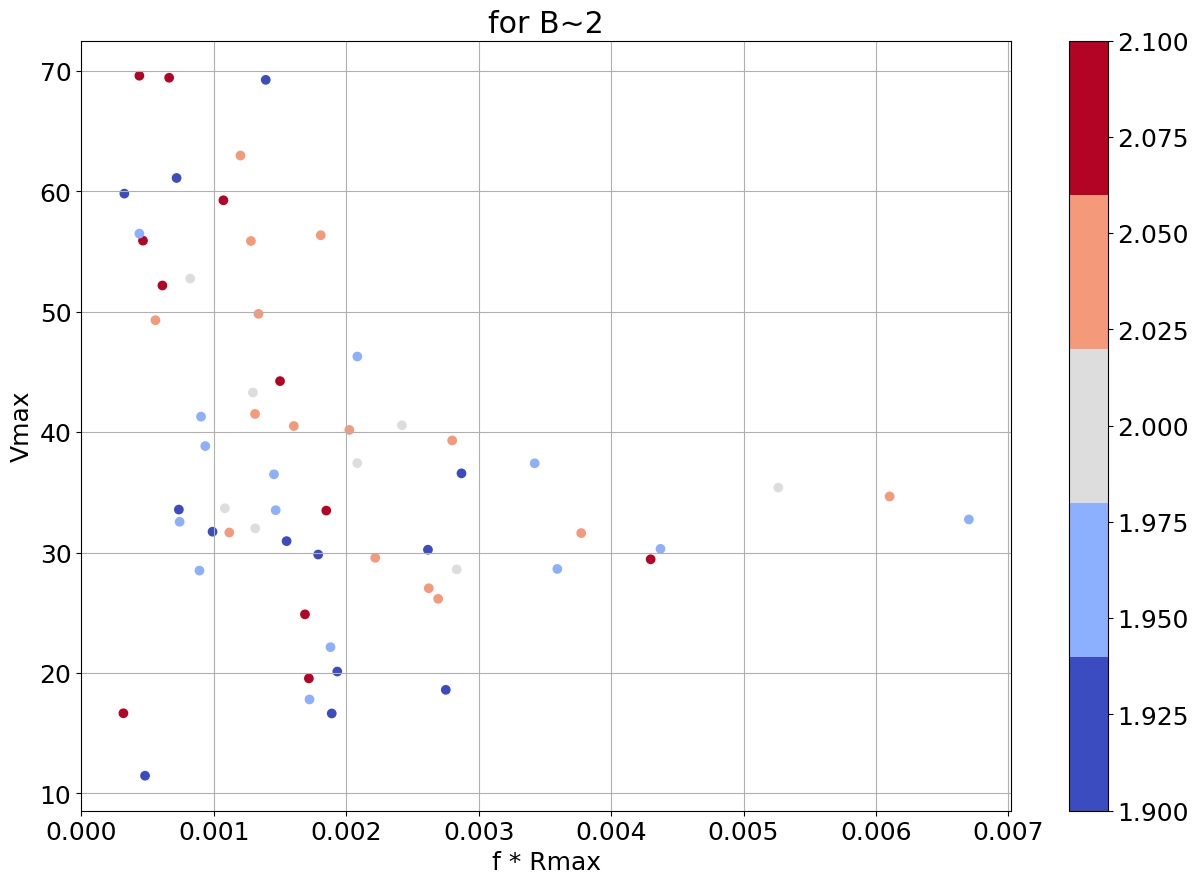

In [139]:
d = dsg.where(abs(dsg.B_hol - 2) < 0.1, drop=True)
plt.title('for B~2')
plt.scatter(d.Rmax_1D * abs(d.fcor), d.Vmax_1D, c=d.B_hol, cmap=cm.get_cmap('coolwarm', 5), vmin=1.9, vmax=2.1);plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')

Text(0, 0.5, 'Vmax')

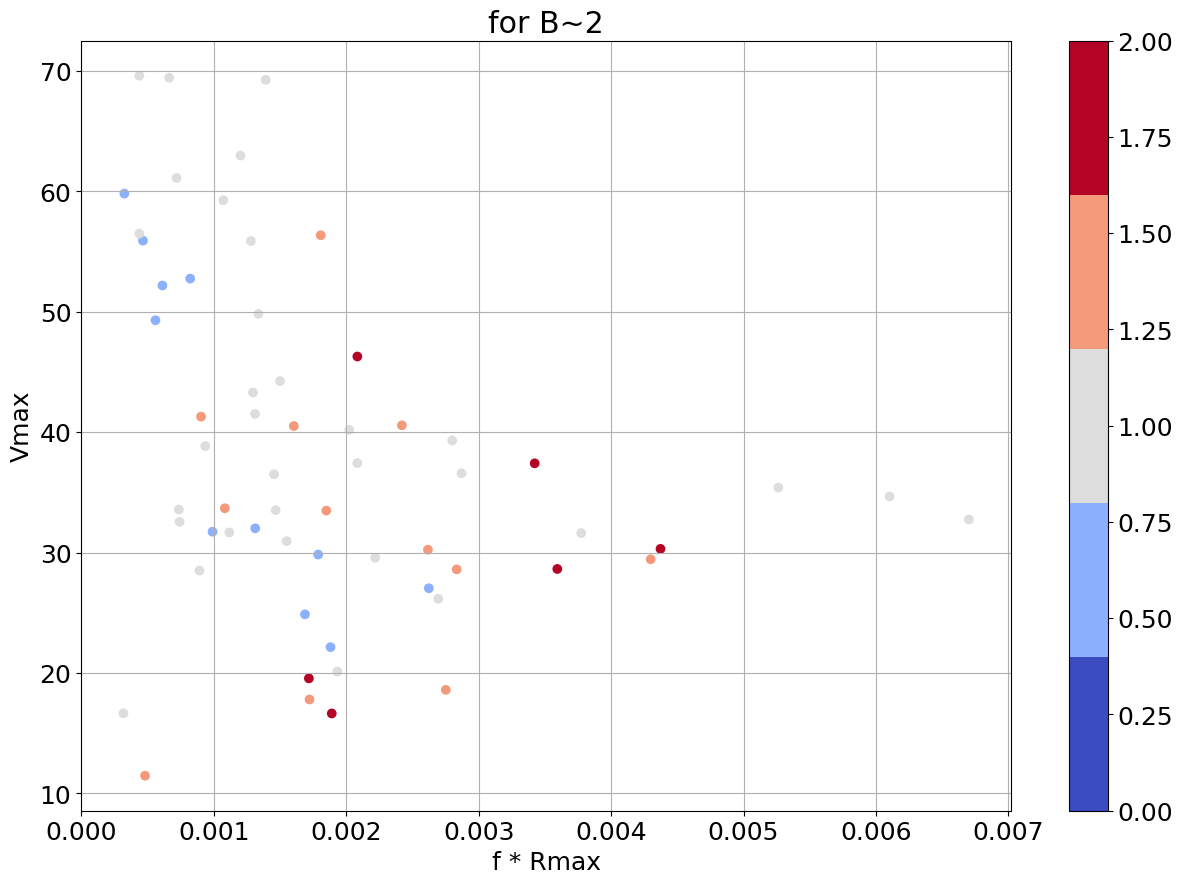

In [142]:
d = dsg.where(abs(dsg.B_hol - 2) < 0.1, drop=True)
plt.title('for B~2')
plt.scatter(d.Rmax_1D * abs(d.fcor), d.Vmax_1D, c=d.life_vmax_idx, cmap=cm.get_cmap('coolwarm', 5), vmin=0, vmax=2);plt.colorbar()
plt.grid()
plt.xlabel('f * Rmax');plt.ylabel('Vmax')